# Setup

In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import cluster

In [2]:
INPUT_DIR = "../../data/input/"
OUTPUT_DIR = "../../data/output/"

# Load data

In [3]:
df = pd.read_csv(OUTPUT_DIR + "dataset.csv")
df.head()

,AvgCyclomatic,AvgEssential,AvgLine,CountDeclClass,CountDeclClassMethodRatio,CountDeclClassVariableRatio,CountDeclFunction,CountDeclInstanceMethodRatio,CountDeclMethod,CountDeclMethodDefaultRatio,...,AvgCountClassBase,AvgCountClassCoupled,AvgCountClassDerived,MaxInheritanceTree,AvgPercentLackOfCohesion,AvgCountInput,AvgCountOutput,AvgCountPath,MaxNesting,Bug
0,1.0,1.0,9.0,1.0,0.0,9.0,17.0,1.0,17.0,0.176471,...,1.0,18.0,1.0,1.0,70.0,6.176471,3.941176,2.058824,2.0,0
1,2.0,1.0,8.0,2.0,0.0,0.0,21.0,1.0,21.0,0.000000,...,1.5,8.5,0.0,1.0,33.5,6.142857,3.142857,2.666667,3.0,0
2,2.0,1.0,14.0,1.0,0.0,2.0,21.0,1.0,21.0,0.000000,...,3.0,53.0,0.0,2.0,90.0,4.476190,4.142857,5.571429,4.0,0
3,2.0,1.0,29.0,1.0,0.0,17.0,8.0,1.0,8.0,0.125000,...,1.0,26.0,0.0,1.0,0.0,8.750000,5.750000,2.750000,2.0,0
4,2.0,1.0,17.0,1.0,0.0,0.0,6.0,1.0,6.0,0.000000,...,1.0,17.0,0.0,4.0,66.0,5.833333,8.500000,4.333333,2.0,0


# Correlation analysis

<AxesSubplot:>

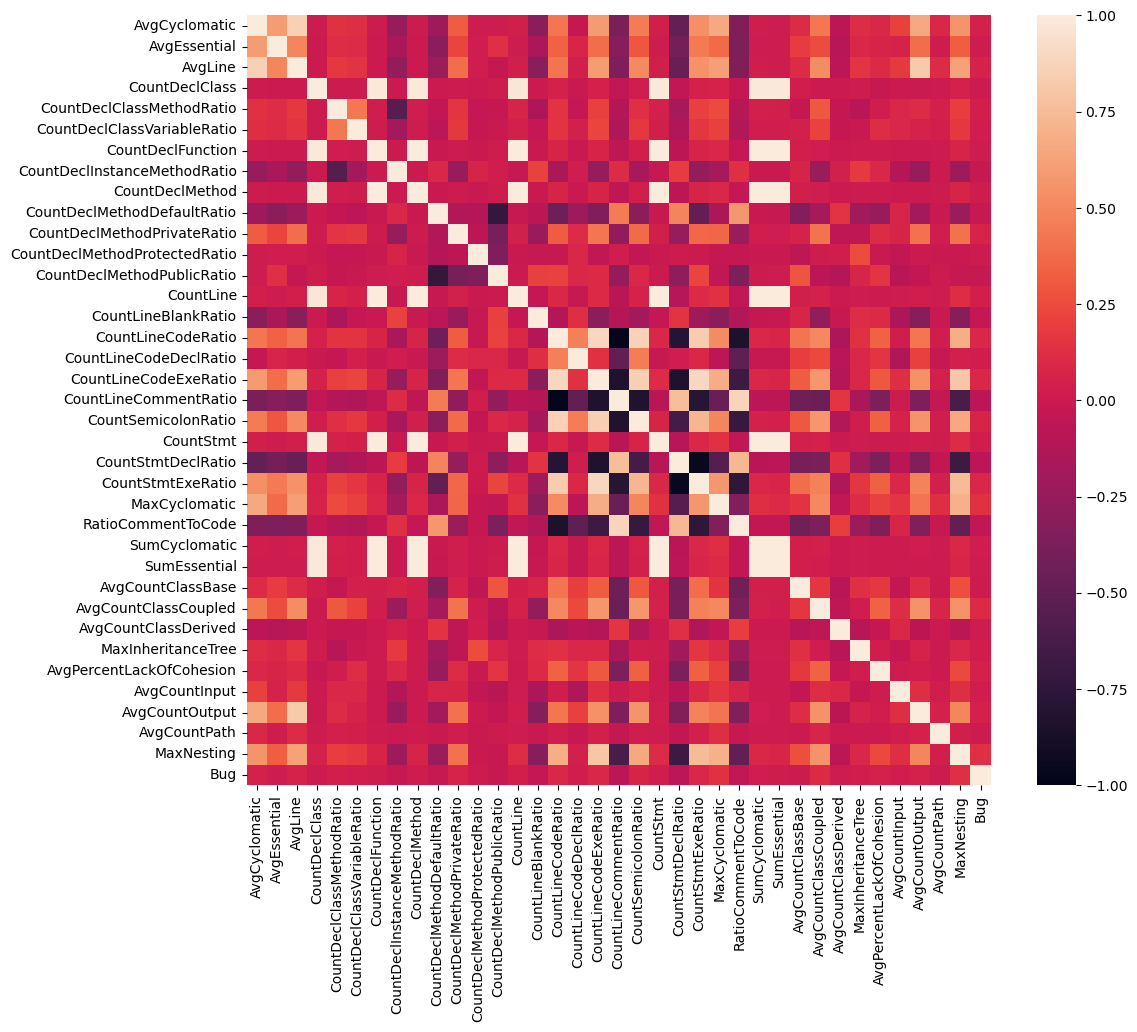

In [4]:
plt.figure(figsize=(12, 10))
r = df.corr()
sns.heatmap(r, vmin=-1, vmax=1)

## Variables clustering

In [5]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

dissimilarity = 1 - abs(r)
Z = linkage(squareform(dissimilarity), method="complete")

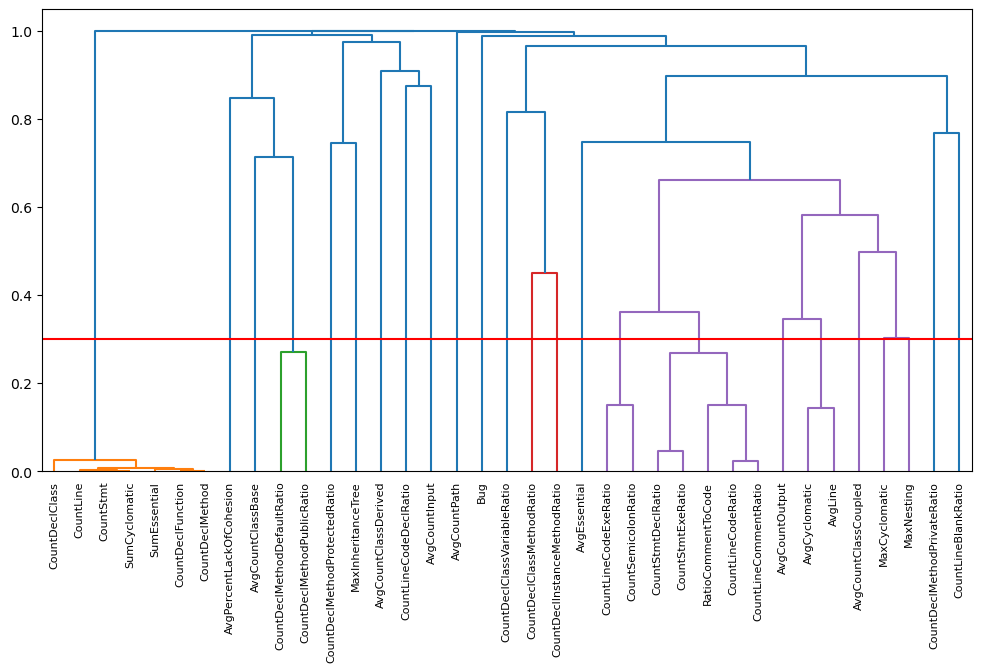

In [6]:

plt.figure(figsize=(12, 6))
dendrogram(Z, labels=df.columns, orientation="top", leaf_rotation=90)
plt.axhline(y = .3, c="red")

Let us retain one independant variable for every cluster with a dissimilarity below 0.3.

In [7]:
df = df.drop(['CountDeclClass', 'CountStmt', 'SumCyclomatic', 'SumEssential', 'CountDeclFunction', 'CountDeclMethod', 
              'CountDeclMethodDefaultRatio', 'CountLineCodeExeRatio', 'CountSemicolonRatio', 'CountStmtDeclRatio',
              'CountStmtExeRatio', 'CountLineCodeRatio', 'CountLineCommentRatio', 'AvgLine'], axis=1)

The dissimilartity dendrogram of the remaining variable confirm that no two variables ahve a correlation above 0.70.

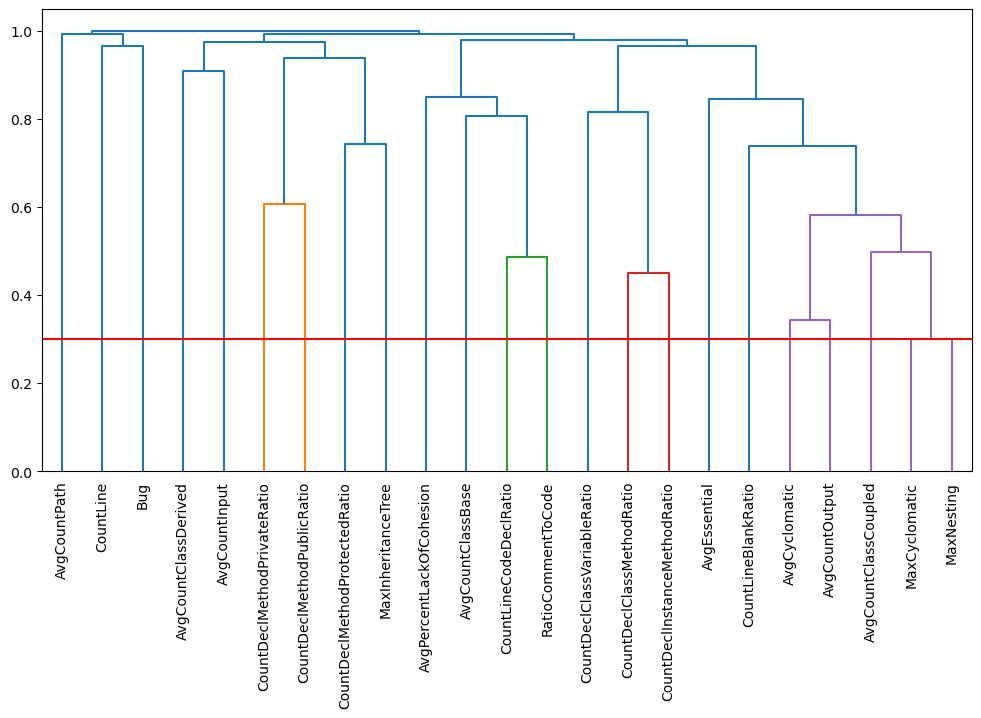

In [8]:
dissimilarity = 1 - abs(df.corr())
Z = linkage(squareform(dissimilarity), method="complete")

plt.figure(figsize=(12, 6))
dendrogram(Z, labels=df.columns, orientation="top", leaf_rotation=90)
plt.axhline(y = .3, c="red")

Lets shuffle this final dataset and save this new order.

In [9]:
df = df.sample(frac=1).reset_index(drop=True)
df.to_csv(OUTPUT_DIR + "dataset_independent.csv", index=False)

## 10 Fold Cross Validation

To validate our models, we will use a 10 fold cross validation. Lets split the data into equal sets.

In [10]:
import numpy as np

df = pd.read_csv(OUTPUT_DIR + "dataset_independent.csv")
sets = np.array_split(df,10)

train_sets = []
test_sets = []
for i in range(10):
    train_sets.append( pd.concat(sets[:i] + sets[i+1:]) )
    test_sets.append( sets[i] )

Lets make sure that there are enough bugs in each of the test sets.

In [11]:
test_sets_info = pd.DataFrame({"BugCount"   : [ts.Bug.sum() for ts in test_sets],
                               "TotalCount" : [ts.Bug.count() for ts in test_sets]})
test_sets_info["ProportionBugs"] = test_sets_info["BugCount"] / test_sets_info["TotalCount"]
test_sets_info

,BugCount,TotalCount,ProportionBugs
0,105,7525,0.013953
1,105,7525,0.013953
2,98,7525,0.013023
3,78,7525,0.010365
4,99,7525,0.013156
5,109,7525,0.014485
6,88,7525,0.011694
7,97,7525,0.012890
8,101,7525,0.013422
9,94,7525,0.012492


## Balancing the Training Sets

Lets create balanced training sets using the undersampling and SMOTE strategies.

In [12]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

undersampled_sets = []
smote_sets = []
for ts in train_sets:
    train_set_x = ts.drop("Bug", axis=1)
    train_set_y = ts.Bug

    rus = RandomUnderSampler()
    resampled_x, resampled_y = rus.fit_resample(train_set_x, train_set_y)
    undersampled_sets.append(pd.merge(resampled_x, resampled_y, left_index=True, right_index=True))

    smote = SMOTE()
    resampled_x, resampled_y = smote.fit_resample(train_set_x, train_set_y)
    smote_sets.append(pd.merge(resampled_x, resampled_y, left_index=True, right_index=True))


Lets save our new training and testing sets.

In [13]:
for i in range(10):
    undersampled_sets[i].to_csv(OUTPUT_DIR + "train_set{}_undersampling.csv".format(i), index=False)
    smote_sets[i].to_csv(OUTPUT_DIR + "train_set{}_smote.csv".format(i), index=False)
    test_sets[i].to_csv(OUTPUT_DIR + "test_set{}.csv".format(i), index=False)